In [177]:
import math
import pandas as pd
import numpy as np
from pykalman import KalmanFilter

import statsmodels.tsa.stattools as smts
import statsmodels.api as sm

from matplotlib import pyplot as plt

### Kalman Filter 

In [148]:
# read data
stk1 = pd.read_csv("../ib-data/nyse-daily-tech/DATA.csv")
stk2 = pd.read_csv("../ib-data/nyse-daily-tech/OOMA.csv")
N = min(len(stk1), len(stk2))

stk1 = stk1[-N:].reset_index(drop=True)
stk2 = stk2[-N:].reset_index(drop=True)

# ensure both arrays are of same length
stk1_array = np.log(stk1["close"][:, np.newaxis])
stk2_array = np.log(stk2["close"][:, np.newaxis])

# observation matrix
C = np.hstack((np.ones_like(stk2_array), stk2_array))
C = C.reshape(N, 1, 2)

# state transition matrix
T = np.array([[[1, 0], 
              [0, 1]]])
T = T.repeat(N - 1, axis = 0)

In [149]:
kf = KalmanFilter(em_vars=['transition_covariance', 
                           'observation_covariance', 
                           'initial_state_mean', 
                           'initial_state_covariance'], 
                  transition_matrices=T,
                  observation_matrices=C,
                  n_dim_state=2, 
                  n_dim_obs=1)

In [164]:
kf.em(X=stk1_array, n_iter=50)

In [165]:
filtered_state_means, filtered_state_covariances = kf.filter(X=stk1_array)

In [144]:
filtered_state_means.shape

(874, 2)

### Calculate using both Rolling Least Squares and Kalman Filter

In [262]:
def compute_alpha_beta(Y, X):
    ln_Y = np.log(Y)
    ln_X = np.log(X)
    _X = sm.add_constant(ln_X)

    model = sm.OLS(ln_Y, _X)
    results = model.fit()
    beta, alpha = results.params
    return alpha, beta

def generate_pair_df(df1, df2, train_period=52, history_period=252*2):
    df1_history, df1_train = df1[:history_period], df1[history_period:history_period + train_period]
    df2_history, df2_train = df2[:history_period], df2[history_period:history_period + train_period]
    df1_test, df2_test = df1[history_period + train_period:], df2[history_period + train_period:]
    
    testing_period = len(df1_test)

    df_combined = pd.DataFrame()

    df_combined["close1"] = df1_test["close"]
    df_combined["logClose1"] = np.log(df1_test["close"])
    df_combined["close2"] = df2_test["close"]
    df_combined["logClose2"] = np.log(df2_test["close"])
    
    ##################################################################################################
    # compute alpha and beta using rolling OLS
    df_combined = df_combined.reset_index(drop=True)
    alpha_t, beta_t = [], []
    for i in range(testing_period):
        # i-th test day
        df1_window = df1[history_period + i : train_period + history_period + i]['close']
        df2_window = df2[history_period + i : train_period + history_period + i]['close']
        a, b = compute_alpha_beta(df1_window, df2_window)
        alpha_t.append(a)
        beta_t.append(b)
    df_combined["rolling_ols_alpha"] = pd.Series(alpha_t)
    df_combined["rolling_ols_beta"] = pd.Series(beta_t)
    
    ##################################################################################################
    # compute alpha and beta using rolling kalman filter
    # 0. define matrices
    stk1_array = np.log(df1_history["close"][:, np.newaxis])
    stk2_array = np.log(df2_history["close"][:, np.newaxis])
    
    # observation matrix
    C = np.hstack((np.ones_like(stk2_array), stk2_array))
    C = C.reshape(history_period, 1, 2)
    
    # state transition matrix
    I = np.array([[[1, 0], 
                  [0, 1]]])
    T = I.repeat(history_period - 1, axis = 0)
    
    kf = KalmanFilter(em_vars=['transition_covariance', 
                           'observation_covariance', 
                           'initial_state_mean', 
                           'initial_state_covariance'], 
                      transition_matrices=T,
                      observation_matrices=C,
                      n_dim_state=2, 
                      n_dim_obs=1)
    
    # 1. EM training on history to estimate sigmas
    kf.em(X=stk1_array, n_iter=50)
    
    # 2. predict new hidden states (one by one) in testing period
    alpha_t, beta_t = [], []
    
    for i in range(history_period, len(df1)):
#         observations_t = np.log(df1['close'][:i][:, np.newaxis])
#         filtered_state_means_t, filtered_state_covariances_t = kf.filter(X = observations_t)
        
#         # incorporate new data point
#         observation_t1 = np.array([math.log(df1['close'][i])])
#         observation_matrix_t1 = np.array([1, df2['close'][i]]).reshape(1, 2)   
        
#         fsm_t1, fsc_t1 = kf.filter_update(filtered_state_mean=filtered_state_means_t[-1],
#                                           filtered_state_covariance=filtered_state_covariances_t[-1],
#                                           observation=observation_t1,
#                                           transition_matrix=I.reshape(2, 2),
#                                           observation_matrix=observation_matrix_t1)

        observation_t1 = np.array([math.log(df1['close'][i])])
        observation_matrix_t1 = np.array([1, df2['close'][i]]).reshape(1, 2)
        
        kf.transition_matrices = np.vstack((kf.transition_matrices, I.reshape(1, 2, 2)))
        kf.observation_matrices = np.vstack((kf.observation_matrices, observation_matrix_t1.reshape(1, 1, 2)))
        
        observations_t = np.log(df1['close'][:i+1][:, np.newaxis])
        fsm_t, fsc_t = kf.filter(X = observations_t)
        
        alpha_t.append(fsm_t[-1][1])
        beta_t.append(fsm_t[-1][0])
        
    df_combined["kalman_alpha"] = pd.Series(alpha_t[-testing_period: ])
    df_combined["kalman_beta"] = pd.Series(beta_t[-testing_period: ])
    
    return df_combined

In [263]:
rolling_df = generate_pair_df(stk1, stk2)
rolling_df.shape

(318, 8)

### Compare

In [264]:
rolling_df

,close1,logClose1,close2,logClose2,rolling_ols_alpha,rolling_ols_beta,kalman_alpha,kalman_beta
0,74.915,4.316354,10.525,2.353753,0.349798,3.491002,0.018671,4.119840
1,75.400,4.322807,10.225,2.324836,0.340096,3.513788,0.020184,4.116422
2,75.975,4.330404,10.775,2.377229,0.338737,3.518671,0.019772,4.117356
3,76.140,4.332574,10.925,2.391054,0.335275,3.528036,0.019680,4.117565
4,76.895,4.342441,10.825,2.381858,0.328821,3.544129,0.021062,4.114439
5,77.390,4.348858,10.975,2.395620,0.322609,3.559577,0.021436,4.113593
6,77.635,4.352018,10.575,2.358493,0.319080,3.569191,0.022847,4.110407
7,76.255,4.334083,10.575,2.358493,0.316419,3.577152,0.020690,4.115288
8,77.015,4.344000,10.475,2.348991,0.309331,3.594688,0.022149,4.111988
9,77.215,4.346594,10.525,2.353753,0.301125,3.614860,0.022329,4.111581


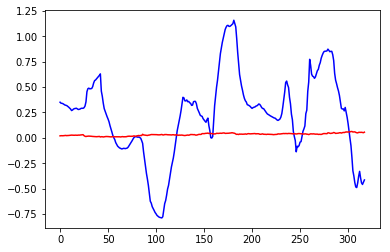

In [265]:
plt.plot(rolling_df["rolling_ols_alpha"], color='b')
plt.plot(rolling_df["kalman_alpha"], color='r')
plt.show()

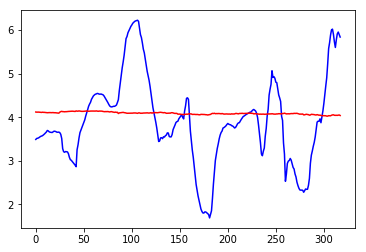

In [266]:
plt.plot(rolling_df["rolling_ols_beta"], color='b')
plt.plot(rolling_df["kalman_beta"], color='r')
plt.show()

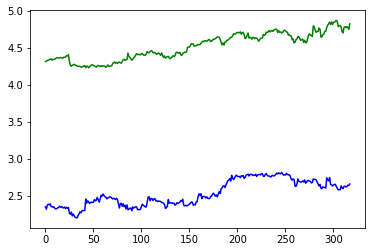

In [267]:
plt.plot(rolling_df['logClose1'], color = 'g')
plt.plot(rolling_df['logClose2'], color = 'b')
plt.show()